In [1]:
from collections import Counter
import scanpy
import pysam
from pathlib import Path
import pandas
import requests
import numpy
import os
import scipy
import gzip
import sys
from matplotlib import pyplot
import matplotlib
import upsetplot
import warnings

In [2]:
EC = str(Path("~/proj/encoded_client").expanduser())
if EC not in sys.path:
    sys.path.append(EC)
from encoded_client import ENCODED

In [3]:
MEX = str(Path("~/proj/mex_gene_archive").expanduser())
if MEX not in sys.path:
    sys.path.append(MEX)

In [4]:
WRS = str(Path("~/proj/woldlab-rna-seq").expanduser())
if WRS not in sys.path:
    sys.path.append(WRS)
from woldrnaseq.plots.scrna_matrix_qc import (
    calculate_qc,
    generate_violin_plot,
    make_pct_mt_scatter,
    make_gene_by_count_scatter,
)

In [5]:
from common import scanpy_load_solo_mtx

In [6]:
%matplotlib inline

In [7]:
gene_id_name_map = {}
genome_dir = Path("~/proj/genome/mm10-M21-male-2.7.9a").expanduser()
with open(genome_dir / "geneInfo.tab", "rt") as instream:
    count = instream.readline()
    for line in instream:
        gene_id, gene_name, gene_type = line.rstrip().split("\t")
        if gene_name == "NULL":
            gene_name = gene_id
        gene_id_name_map[gene_id] = gene_name
        


In [8]:
myrun = scanpy_load_solo_mtx("c2c12/ENCLB129LMS", gene="GeneFull_Ex50pAS")
myrun.obs["star_barcode"] = myrun.obs_names
myrun.obs_names = [x.replace("_", "") for x in myrun.obs_names]
#myrun.var["gene_symbol"] = [gene_id_name_map.get(x, x) for x in myrun.var_names]

calculate_qc(myrun, gene_id_name_map)

myrun.shape

(7253, 81881)

In [9]:
myrunem = scanpy_load_solo_mtx("c2c12/ENCLB129LMS", gene="GeneFull_Ex50pAS", multi="UniqueAndMult-EM.mtx")
myrunem.obs["star_barcode"] = myrunem.obs_names
myrunem.obs_names = [x.replace("_", "") for x in myrunem.obs_names]

calculate_qc(myrunem, gene_id_name_map)

myrunem.shape

(7253, 81881)

In [10]:
ucirun = scanpy.read_h5ad("c2c12/ENCLB129LMS/ENCFF914DEE.h5ad")
ucirun.obs_names = [x.split("_")[0] for x in ucirun.obs['Unnamed: 0'].values]
ucirun.var_names = [x.split("-")[0] for x in ucirun.var["x"].values]
#ucirun.var["gene_symbol"] = [gene_id_name_map.get(x, x) for x in ucirun.var_names]

calculate_qc(ucirun, gene_id_name_map)

In [11]:
Counter([x.split("_")[1] for x in ucirun.obs["Unnamed: 0"].values])

Counter({'9kB': 1352,
         '9kE': 1279,
         '9kF': 910,
         '9kC': 1295,
         '9kA': 1530,
         '9kD': 1319})

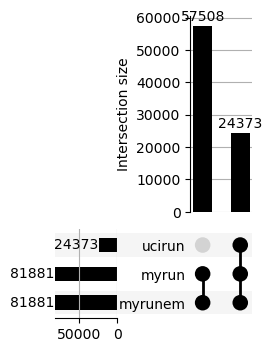

In [12]:
upset_gene_contents = upsetplot.from_contents({
    'myrun': myrun.var_names,
    'myrunem': myrunem.var_names,
    'ucirun': ucirun.var_names,
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)

In [13]:
len(set(myrun.obs_names)), myrun.obs_names.shape

(7253, (7253,))

In [14]:
len(set(ucirun.obs_names)), ucirun.obs_names.shape

(7425, (7685,))

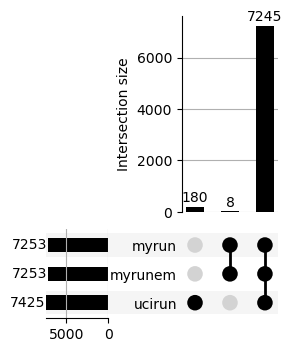

In [15]:
upset_barcode_contents = upsetplot.from_contents({
    'myrun': myrun.obs_names,
    'myrunem': myrunem.obs_names,
    'ucirun': set(ucirun.obs_names),
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_barcode_contents, fig=f, show_counts=True)

In [16]:
warnings.filterwarnings("ignore", "Vertical orientation")

# STAR Violin

... storing 'gene_name' as categorical


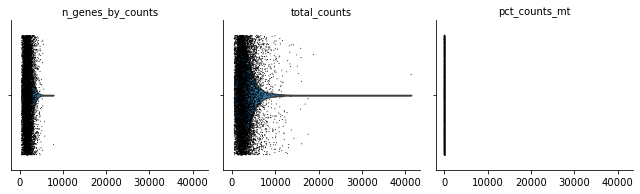

In [17]:
ag = generate_violin_plot(myrun)

# STAR Violin EM

... storing 'gene_name' as categorical


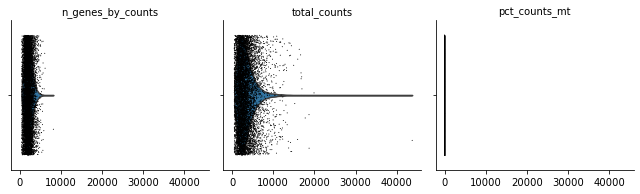

In [18]:
ag = generate_violin_plot(myrunem)

# UCI Violin

... storing 'gene_name' as categorical


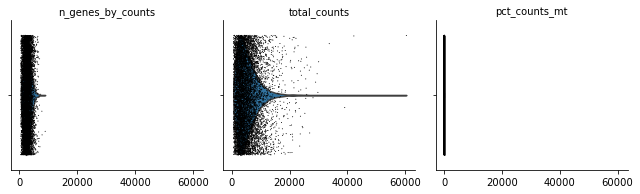

In [19]:
ag = generate_violin_plot(ucirun)

# STAR pct mt

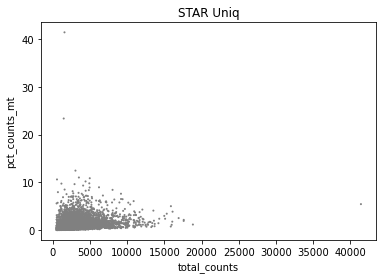

In [20]:
f = make_pct_mt_scatter(myrun, "STAR Uniq")

# STAR EM pct mt

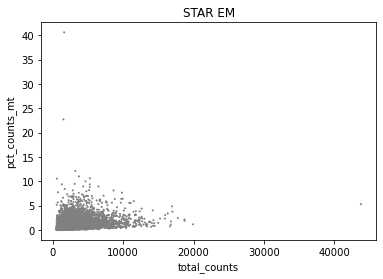

In [21]:
f = make_pct_mt_scatter(myrunem, "STAR EM")

# UCI pct mt

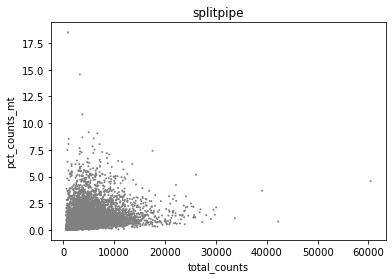

In [22]:
f = make_pct_mt_scatter(ucirun, "splitpipe")

# STAR gene by count

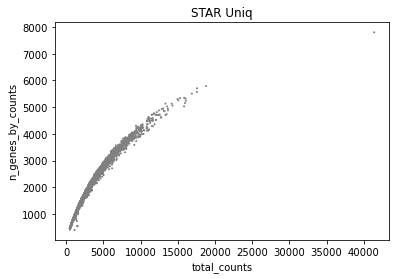

In [23]:
f = make_gene_by_count_scatter(myrun, "STAR Uniq")

# STAR EM gene by count

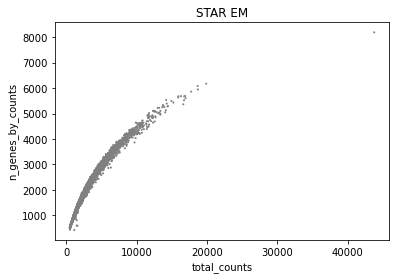

In [24]:
f = make_gene_by_count_scatter(myrunem, "STAR EM")

# UCI gene by count

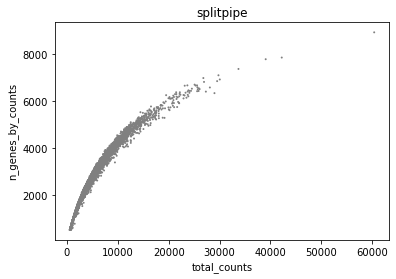

In [25]:
f = make_gene_by_count_scatter(ucirun, "splitpipe")

# STAR highest genes

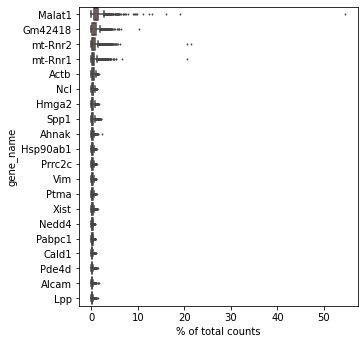

In [26]:
scanpy.pl.highest_expr_genes(myrun, n_top=20, gene_symbols="gene_name")

# STAR EM highest genes

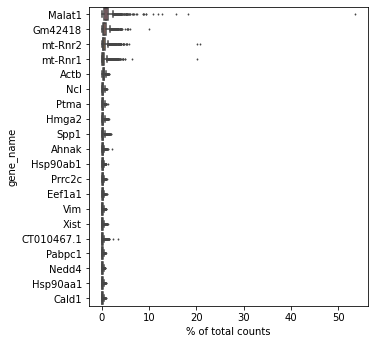

In [27]:
scanpy.pl.highest_expr_genes(myrunem, n_top=20, gene_symbols="gene_name")

# UCI highest genes

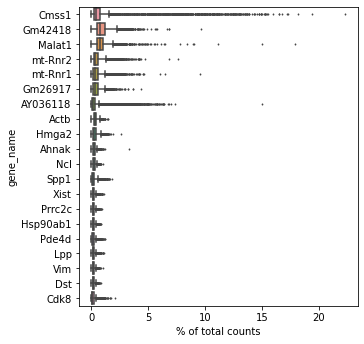

In [28]:
scanpy.pl.highest_expr_genes(ucirun, n_top=20, gene_symbols="gene_name")

# STAR expression sum

In [29]:
myrun.X.sum()

22873560.0

# STAR EM expression sum

In [30]:
myrunem.X.sum()

24186194.0

# UCI expression sum

In [31]:
ucirun.X.sum()

41020536.0

# WARNING

There are duplicate UCI barcodes after making them compatible with star. I think they had a _pbN after them. This code ends up using the first of the barcodes to compare with the STAR run.

In [32]:
ucirun.obs_names_make_unique()

In [33]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    return cors


In [34]:
def compute_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [35]:
def set_all_spines(ax, state):
    for name in ["left", "right", "top", "bottom"]:
        ax.spines[name].set_visible(state)
        ax.tick_params(
            axis='both', 
            which='both', 
            bottom=False,
            labelbottom=False, 
            top=False, 
            labeltop=False,
            right=False,
            labelright=False,
            left=False, 
            labelleft=False)


def plot_cell_correlation_histogram(
    table, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None
):
    #fontname = 'Arial'
    override_labels = {
        'Alevin': 'Salmon Alevin (EM)',
        'Kallisto EM': 'Kallisto Bus (EM)'
    }
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    #f.suptitle('Per-cell {} correlation'.format(correlation_name), fontsize=fontsize)
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    
    for i in range(0, plot_size):
        for j in range(i+1, plot_size):
            set_all_spines(axes[i, j], False)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            x_label = override_labels.get(name_x, name_x)
            y_label = override_labels.get(name_y, name_y)
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if xlim is not None:
                ax.set_xlim(xlim)
            #set_all_spines(ax, True)
            if x == 0:
                ax.set_ylabel(y_label, fontname=fontname, fontsize=fontsize)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            nantext=""
            if count_nans:
                nantext="\nNaNs {}".format(table[name_x][name_y].isna().sum())
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
            #ax.annotate(f'Mean {mean}\nMedian {median}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
    for y in range(plot_size):
        x_label = override_labels.get(programs[y], programs[y])
        axes[0, y].set_title(x_label, fontname=fontname, fontsize=fontsize)
        axes[plot_size-1, y].set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    #f.tight_layout()
    return f

In [36]:
common_cell_set = set(ucirun.obs_names).intersection(myrun.obs_names)
common_gene_set = set(ucirun.var_names).intersection(myrun.var_names)

common_cells = [x for x in ucirun.obs_names if x in common_cell_set]
common_genes = [x for x in ucirun.var_names if x in common_gene_set]

In [37]:
myrun[common_cells,common_genes]

View of AnnData object with n_obs × n_vars = 7245 × 24373
    obs: 'counts', 'ngenes', 'star_barcode', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [38]:
datasets = {
    "myrun": myrun[common_cells, common_genes].to_df().T,
    "myrun em": myrunem[common_cells, common_genes].to_df().T,
    "ucirun": ucirun[common_cells, common_genes].to_df().T,
}

In [39]:
cors = compute_correlations(datasets)

# All vs All Spearman Correlation

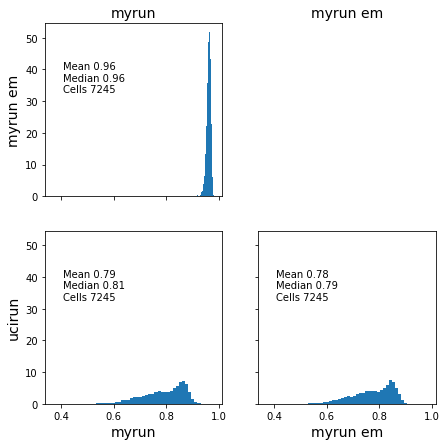

In [40]:
f = plot_cell_correlation_histogram(cors)